# Paper Plots

As discussed [here](https://hackmd.io/gTiEKcmZSqaUfwom_p4HGg#:~:text=Paper-,outline,-%3A)

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36181,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:45549,Total threads: 4
Dashboard: /user/jbusecke/proxy/39775/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:45299,


In [3]:
import gcsfs
import xarray as xr
import numpy as np
import cartopy
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram


from scale_aware_air_sea.utils import open_zarr
from scale_aware_air_sea.parameters import get_params

from xarrayutils.plotting import shaded_line_plot, letter_subplots
%matplotlib inline

In [4]:
import numpy as np
from scipy import ndimage as nd

# from https://stackoverflow.com/questions/3662361/fill-in-missing-values-with-nearest-neighbour-in-python-numpy-masked-arrays
def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """
    #import numpy as np
    #import scipy.ndimage as nd

    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

def fill_da(da: xr.DataArray) -> xr.DataArray:
    data = da.data
    filled_data = fill(data, invalid=data==0)# the land on the lon/lat values 
    #are filled with 0 that is really bad
    da.data = filled_data
    return da

def centered_shrink_axes(ax, factor):
    bbox = ax.get_position()
    left = bbox.x0+(bbox.width*factor/2)
    bottom = bbox.y0+(bbox.height*factor/2)
    width = bbox.width * factor
    height = bbox.height * factor
    ax.set_position([left, bottom, width, height])

In [5]:
# load global parameters
params = get_params('v0.7.0', test=False) 
projection = cartopy.crs.Robinson(200)
primary_algo = 'ecmwf'
n_subsample = 4
subsample = dict(xt_ocean=slice(0, None, n_subsample), yt_ocean=slice(0,None, n_subsample))

fs = gcsfs.GCSFileSystem()
# 🚨 this was not written fully, only use for internal testing
mapper_filter_flux_decomposition_daily = fs.get_mapper('leap-persistent/jbusecke/scale-aware-air-sea/results/CM26_fluxes_filter_decomposed_daily_v0.7.0_old.zarr')
ds_small_scale_daily = open_zarr(mapper_filter_flux_decomposition_daily)
# END

mapper_filter_flux_decomposition_monthly = fs.get_mapper(params['paths']['CM26']['filter_decomposition_monthly'])
mapper_filter_flux_decomposition_mean = fs.get_mapper(params['paths']['CM26']['filter_decomposition_mean'])
mapper_coarse_flux_decomposition_mean = fs.get_mapper(params['paths']['CM26']['coarse_decomposition_mean'])

ds_small_scale_monthly = open_zarr(mapper_filter_flux_decomposition_monthly)
ds_small_scale_mean = open_zarr(mapper_filter_flux_decomposition_mean)
ds_small_scale_mean_coarse = open_zarr(mapper_coarse_flux_decomposition_mean)

## Mean maps and histogram

In [6]:
# fill the nans in lon/lat
ds_plot_mean=ds_small_scale_mean.sel(algo=primary_algo)
ds_plot_monthly=ds_small_scale_monthly.sel(algo=primary_algo)

# 🚨 only use for internal testing
ds_plot_daily=ds_small_scale_daily.sel(algo=primary_algo)

# the lon/lat coords have missing values which are dletter_subplotsined by 0!!
# that is pretty silly, since 0 is a valid value in each array...
for var in ['geolon_t', 'geolat_t']:
    ds_plot_mean.coords[var] = fill_da(ds_plot_mean[var].load())
    ds_plot_monthly.coords[var] = fill_da(ds_plot_monthly[var].load())

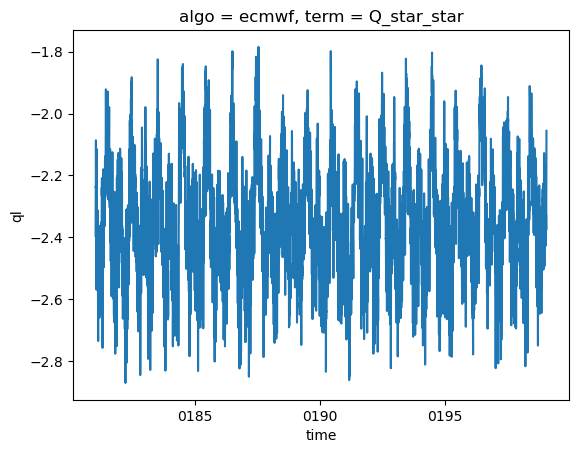

In [12]:
ds_plot_daily['ql'].mean(['xt_ocean', 'yt_ocean']).plot()

ql
maps
hist


/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


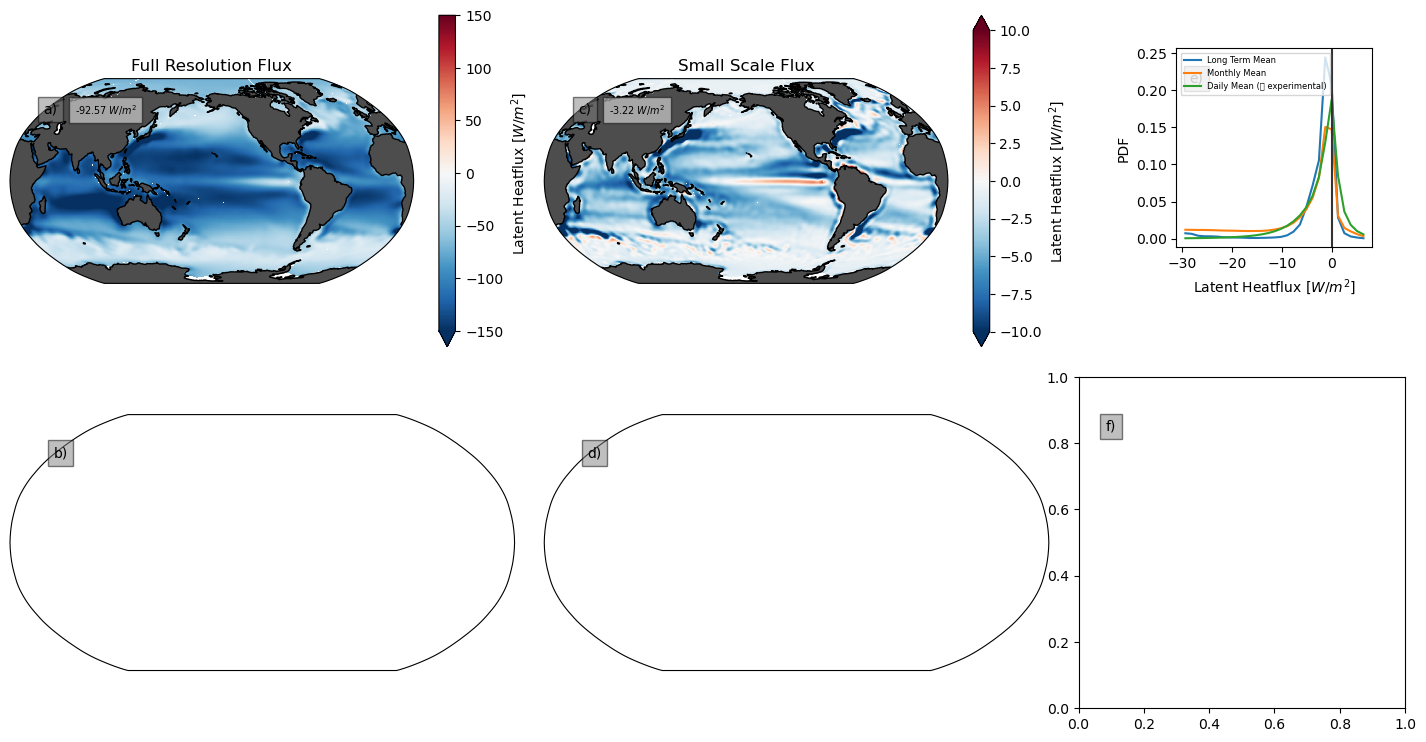

In [13]:
fig = plt.figure(figsize=[18,9])
gs = fig.add_gridspec(4, 8)
# axarr_map_highres = [fig.add_subplot(gs[i,0:3], projection=projection) for i in [0,2]]
# axarr_map_lowres = [fig.add_subplot(gs[i,0:3], projection=projection) for i in [1,3]]
axarr_map_highres = [fig.add_subplot(gs[i:i+2,0:3], projection=projection) for i in [0,2]]
axarr_map_small = [fig.add_subplot(gs[i:i+2,3:6], projection=projection) for i in [0,2]]
axarr_hist =[fig.add_subplot(gs[i:i+2,6:]) for i in [0,2]]

label_dict = {
    'ql':'Latent Heatflux [$W/m^2$]',
    'qh':'Sensible Heatflux [$W/m^2$]',
}
vmax_dict = {
    'ql':{'full':150, 'small':10},
    'qh':{'full':50, 'small':3},
}

for var, ax_map_high, ax_map_small, ax_hist in zip(
    ['ql', 'qh'], 
    axarr_map_highres, 
    # axarr_map_lowres, 
    axarr_map_small, 
    axarr_hist
):
    label = label_dict[var]
    print(var)
    print('maps')
    # Map Plot
    for ax, term, vmax, title in [
        (ax_map_high,'Q_H_bar',vmax_dict[var]['full'], 'Full Resolution Flux'), 
        # (ax_map_low,'Q_L_bar', vmax_dict[var]['full'], 'Low Resolution Flux'), 
        (ax_map_small,'Q_star_star', vmax_dict[var]['small'], 'Small Scale Flux'),
    ]:
        da = ds_plot_mean[var].sel(term=term)
        da = da.isel(**subsample)
        da.plot(
            ax=ax,
            transform=cartopy.crs.PlateCarree(),
            x='geolon_t',
            y='geolat_t',
            vmax=vmax,
            center=0,
            rasterized=True,
            cbar_kwargs={'label':label},
        )
        ax.add_feature(cartopy.feature.LAND, color='0.3')
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.set_title(title)
        mean_da = da.weighted(da.area_t).mean().load()
        ax.text(0.16, 0.81, f"{mean_da.data:.2f} $W/m^2$", 
                ha='left',va='bottom', 
                fontsize=7, transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.5)
               )
    print('hist')
    #Histogram Plot
    bins = np.linspace(-30, 7, 30)
    # use xhistogram for this
    hist_mean = histogram(ds_plot_mean[var], bins=bins, density=True)
    hist_monthly = histogram(ds_plot_monthly[var], bins=bins, density=True)
    
    hist_kwargs = {'alpha':0.5}
    hist_mean.plot(ax=ax_hist, label='Long Term Mean')
    hist_monthly.plot(ax=ax_hist, label='Monthly Mean')
    
    # 🚨 only use for internal testing
    hist_daily = histogram(ds_plot_daily[var].isel(time=slice(0,360)), bins=bins, density=True, dim=['xt_ocean', 'yt_ocean']).mean('time')
    hist_daily.plot(ax=ax_hist, label='Daily Mean (🚨 experimental)')
    # 🚨 END
    
    ax_hist.legend(fontsize=6)
    ax_hist.set_title('')
    ax_hist.set_xlabel(label)
    ax_hist.set_ylabel('PDF')
    ax_hist.axvline(0.0, color='0.2')
    centered_shrink_axes(ax_hist, 0.6)
    break
letter_subplots(np.array(axarr_map_highres+axarr_map_small+axarr_hist), box_color='0.5', fontsize=10)
plt.show()

## Scatter: Q_H_bar vs Q_L_bar

In [74]:
from xhistogram.xarray import histogram

bins = {'qh':np.arange(-800, 100, 2), 'ql':np.arange(-400, 50, 1)}

hist_dict = {}

for var in ['qh', 'ql']:
    print(f"Processing Histogram for {var}")
    da_plot=ds_small_scale_monthly[var].sel(algo=primary_algo)
    
    highres = da_plot.sel(term='Q_H_bar')
    highres.name = f'High Resolution {var}'
    
    lowres = da_plot.sel(term='Q_L_bar')
    lowres.name = f'Low Resolution {var}'
    
    h = histogram(highres, lowres, bins=[bins[var], bins[var]])
    
    hist_dict[var] = h.load()

Processing Histogram for qh
Processing Histogram for ql


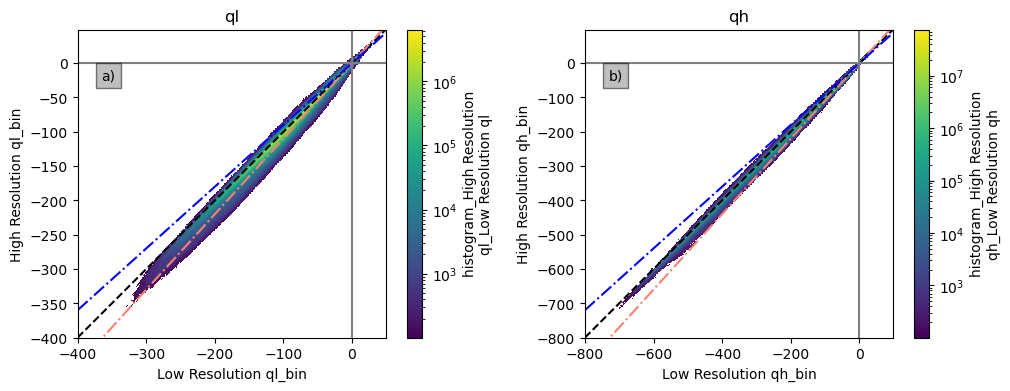

In [118]:
import matplotlib.colors as colors

fig, axarr = plt.subplots(ncols=2, figsize=[12,4])

for var, ax in zip(['ql', 'qh'], axarr.flat):
    h = hist_dict[var]
    h = h.where(h>100)
    vmin=h.min()
    vmax=h.max()
    norm=colors.LogNorm(vmin=vmin, vmax=vmax)
    h.plot(ax=ax,norm=norm)
    
    ax.plot(bins[var], bins[var], ls='--', color='k')
    ax.plot(bins[var], bins[var]*1.1, ls='-.', color='salmon')
    ax.plot(bins[var], bins[var]*0.9, ls='-.', color='blue')
    ax.axhline(0, color='0.5')
    ax.axvline(0, color='0.5')
    ax.set_xlim(bins[var].min(), bins[var].max())
    ax.set_ylim(bins[var].min(), bins[var].max())
    ax.set_aspect('equal')
    ax.set_title(var)
    
letter_subplots(axarr, box_color='0.5', fontsize=10)
    
# # zoom ins
# for var in hist_dict.keys():
#     plt.figure()
#     h = hist_dict[var]
#     h = h.where(h>0)
#     vmin=h.min()
#     vmax=h.max()
#     norm=colors.LogNorm(vmin=vmin, vmax=vmax)
#     h.plot(norm=norm)
    
#     plt.plot(bins[var], bins[var], ls='--', color='salmon')
#     plt.plot(bins[var]*0.9, bins[var], ls='-.', color='salmon')
#     plt.plot(bins[var], bins[var]*0.9, ls='-.', color='salmon')
#     plt.axhline(0, color='0.5')
#     plt.axvline(0, color='0.5')
#     plt.xlim(bins[var].min()/5, bins[var].max())
#     plt.ylim(bins[var].min()/5, bins[var].max())

In [109]:
from xhistogram.xarray import histogram

bins = {'qh':np.arange(-800, 100, 2), 'ql':np.arange(-400, 50, 1)}

hist_dict_relative = {}

for var in ['qh', 'ql']:
    print(f"Processing Histogram for {var}")
    da_plot=ds_small_scale_monthly[var].sel(algo=primary_algo)
    da_plot = da_plot.isel(time=slice(0,12))
    
    highres = da_plot.sel(term='Q_H_bar')
    highres.name = f'High Resolution {var}'
    
    small_scale = da_plot.sel(term='Q_star_star')
    small_scale.name = f'Small Scale {var}'
    
    h_rel = histogram(highres, small_scale, bins=[bins[var], np.linspace(-60, 60, 50)])
    
    hist_dict_relative[var] = h_rel.load()

Processing Histogram for qh
Processing Histogram for ql


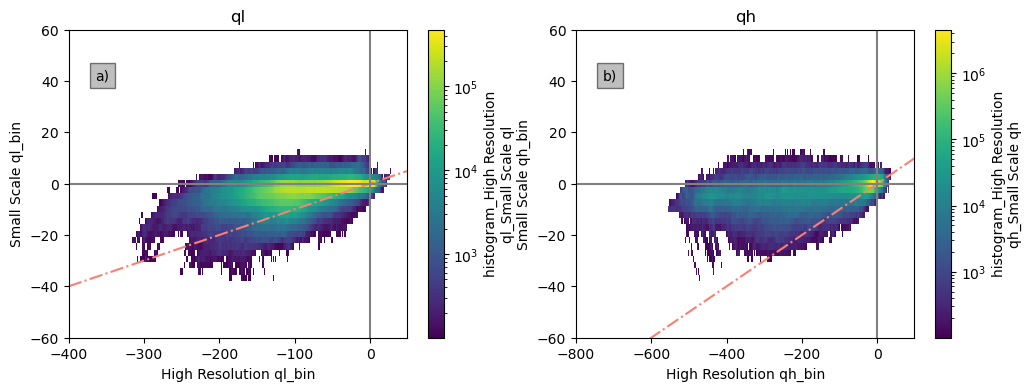

In [112]:
fig, axarr = plt.subplots(ncols=2, figsize=[12,4])

for var, ax in zip(['ql', 'qh'], axarr.flat):
    h = hist_dict_relative[var]
    h = h.where(h>100)
    vmin=h.min()
    vmax=h.max()
    norm=colors.LogNorm(vmin=vmin, vmax=vmax)
    h.plot(ax=ax,norm=norm, x=f'High Resolution {var}_bin')
    
    # ax.plot(bins[var], bins[var], ls='--', color='salmon')
    ax.plot(bins[var], bins[var]*0.1, ls='-.', color='salmon')
    # ax.plot(bins[var], bins[var]*0.9, ls='-.', color='salmon')
    ax.axhline(0, color='0.5')
    ax.axvline(0, color='0.5')
    # ax.set_xlim(bins[var].min(), bins[var].max())
    # ax.set_ylim(bins[var].min(), bins[var].max())
    # ax.set_aspect('equal')
    ax.set_title(var)
    
letter_subplots(axarr, box_color='0.5', fontsize=10)

## Seasonal Climatology of Small Scale Contribution

In [119]:
def global_mean(ds):
    return ds.weighted(ds.area_t).mean(['xt_ocean', 'yt_ocean'])
climatology_small = global_mean(ds_small_scale_monthly).sel(term='Q_star_star').groupby('time.month').mean().load()
climatology_full = global_mean(ds_small_scale_monthly).sel(term='Q_H_bar').groupby('time.month').mean().load()

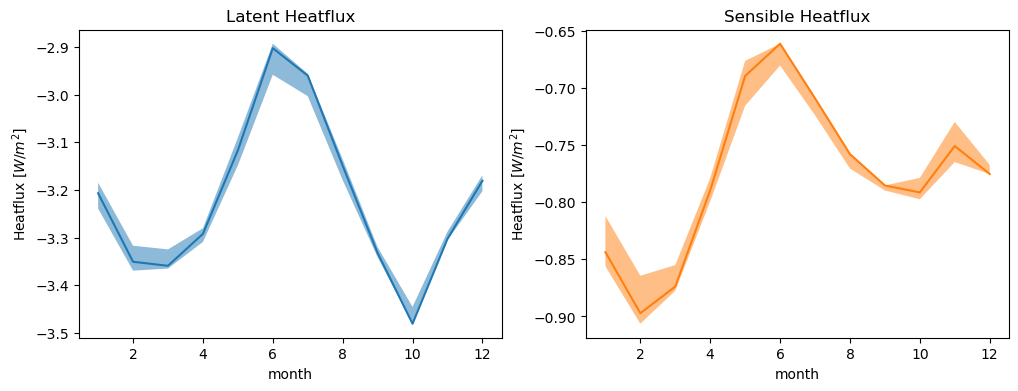

In [175]:
alpha = 0.5

fig = plt.figure(figsize=[12,4])
for i, (var, co, label) in enumerate([('ql', 'C0', 'Latent Heatflux'), ('qh', 'C1', 'Sensible Heatflux')]):
    plt.subplot(1,2,i+1)
    da = climatology_small[var]
    da_ref = climatology_small[var].sel(algo=primary_algo)
    shaded_line_plot(
        # climatology_small[var],# full range
        da - da.mean('month') + da_ref.mean('month'),# time mean removed
        'algo',
        spread_style='quantile',
        spreads=[1.0],
        alphas=[alpha],
        line_kwargs={'color':co, 'alpha':0.0},
    )# show the full range
    da_ref.plot(color=co)

    plt.ylabel('Heatflux [$W/m^2$]')
    plt.title(label)
plt.show()

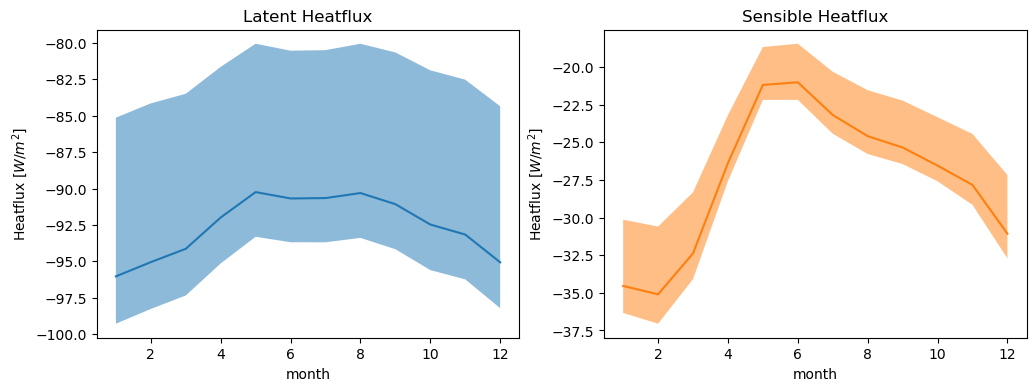

In [179]:
alpha = 0.5
fig = plt.figure(figsize=[12,4])
for i, (var, co, label) in enumerate([('ql', 'C0', 'Latent Heatflux'), ('qh', 'C1', 'Sensible Heatflux')]):
    plt.subplot(1,2,i+1)
    shaded_line_plot(
        climatology_full[var],
        'algo',
        spread_style='quantile',
        spreads=[1.0],
        alphas=[alpha],
        line_kwargs={'color':co, 'alpha':0.0},
    )# show the full range
    climatology_full[var].sel(algo=primary_algo).plot(color=co)

    plt.ylabel('Heatflux [$W/m^2$]')
    plt.title(label)
plt.show()

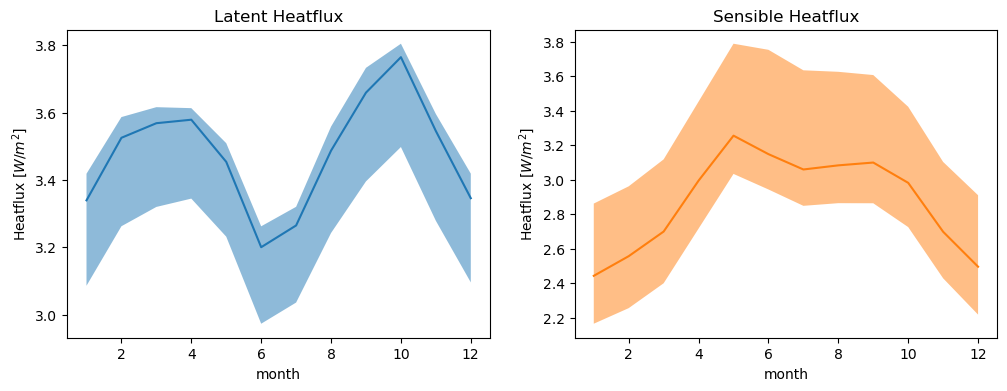

In [178]:
alpha = 0.5
fig = plt.figure(figsize=[12,4])
for i, (var, co, label) in enumerate([('ql', 'C0', 'Latent Heatflux'), ('qh', 'C1', 'Sensible Heatflux')]):
    plt.subplot(1,2,i+1)
    shaded_line_plot(
        climatology_small[var]/climatology_full[var]*100,
        'algo',
        spread_style='quantile',
        spreads=[1.0],
        alphas=[alpha],
        line_kwargs={'color':co, 'alpha':0.0},
    )# show the full range
    (climatology_small[var]/climatology_full[var]*100).sel(algo=primary_algo).plot(color=co)

    plt.ylabel('Heatflux [$W/m^2$]')
    plt.title(label)
plt.show()

## Decomposition of small scale signal

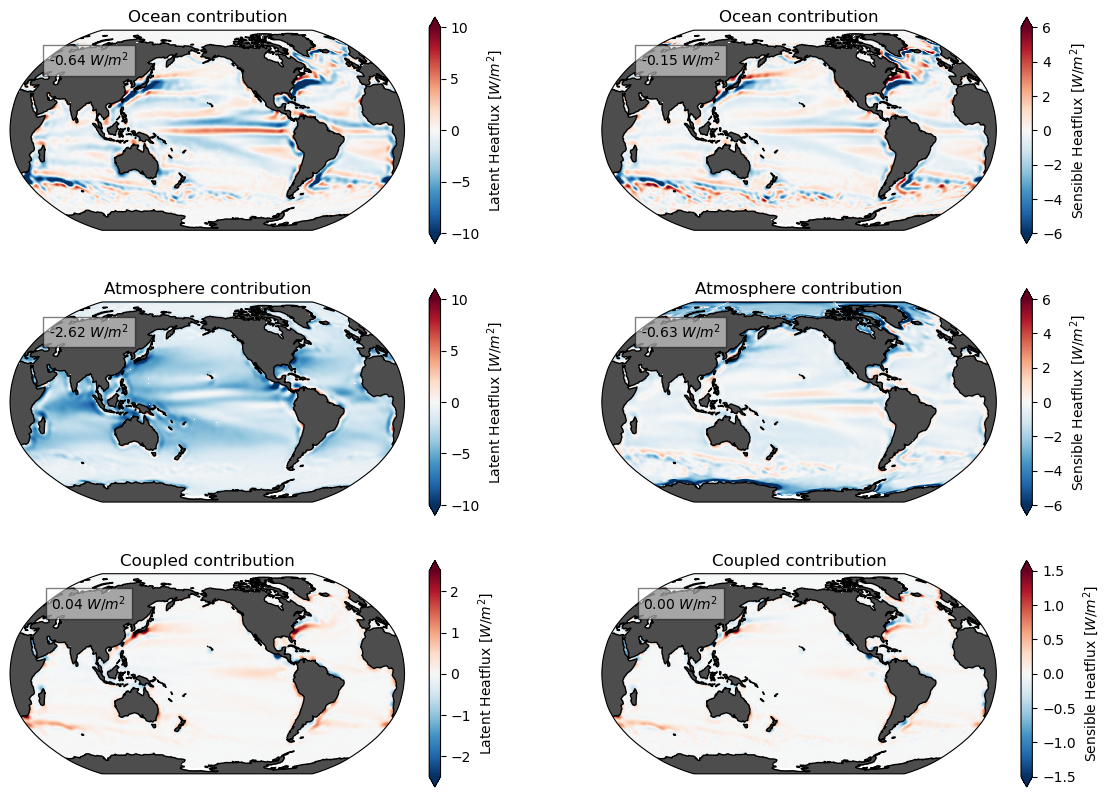

In [68]:
fig, axarr = plt.subplots(figsize=[14,10], ncols=2, nrows=3, subplot_kw={'projection':projection})

ds_plot_mean=ds_small_scale_mean.sel(algo=primary_algo)

# the lon/lat coords have missing values which are defined by 0!!
# that is pretty silly, since 0 is a valid value in each array...
for co in ['geolon_t', 'geolat_t']:
    ds_plot_mean[co] = fill_da(ds_plot_mean[co].load())


for var, (ax_ocean, ax_atmos, ax_coupled), label, vmax_full in [
    ('ql', axarr[:,0].flat, 'Latent Heatflux [$W/m^2$]', 10), 
    ('qh', axarr[:,1].flat, 'Sensible Heatflux [$W/m^2$]', 6)
]:
    
    da_full = ds_plot_mean[var].sel(term='Q_star_star')
    da_ocean = ds_plot_mean[var].sel(term='Q_star_star_ocean')
    da_atmos = ds_plot_mean[var].sel(term='Q_star_star_atmos')
    da_coupled = ds_plot_mean[var].sel(term='Q_star_star') - da_ocean -da_atmos
    # Map Plot
    for da, ax, vmax, component in [
        (da_ocean, ax_ocean, vmax_full, 'Ocean contribution'),
        (da_atmos, ax_atmos, vmax_full, 'Atmosphere contribution'),
        (da_coupled, ax_coupled, vmax_full/4, 'Coupled contribution')
    ]:

        da.isel(**subsample).plot(
            ax=ax,
            transform=cartopy.crs.PlateCarree(),
            x='geolon_t',
            y='geolat_t',
            vmax=vmax,
            rasterized=True,
            cbar_kwargs={'label':label},
        )
        ax.add_feature(cartopy.feature.LAND, color='0.3')
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.set_title(component)
        # add global mean value
        mean_da = da.weighted(da.area_t).mean().load()
        mean_da_full = da_full.weighted(da_full.area_t).mean().load()
        ax.text(
            0.16, 0.81, f"{mean_da.data:.2f} $W/m^2$",
            ha='left',va='bottom', 
            fontsize=7,transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.5)
        )
plt.show()

## Appendix plot: Comparing algorithms

In [124]:
# does the global mean differ?
global_mean = ds_small_scale_mean.weighted(ds_plot_mean.area_t).mean(['xt_ocean', 'yt_ocean']).load()

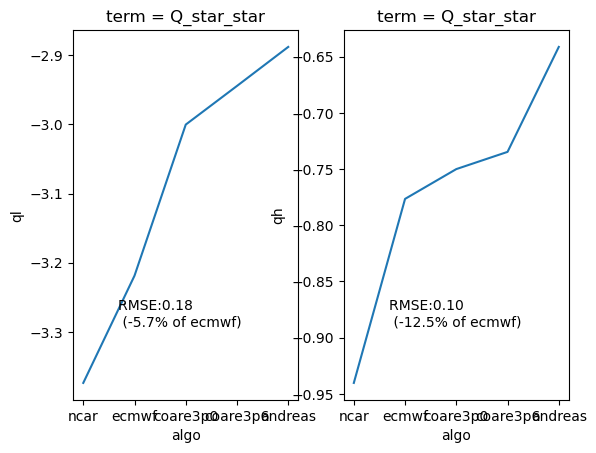

In [142]:
# small scale
fig, axarr = plt.subplots(ncols=2)
for ax,var in zip(axarr.flat,['ql', 'qh']):
    da = global_mean[var].sel(term='Q_star_star')
    da.plot(ax=ax)
    rmse = np.sqrt(((da-da.mean())**2).mean())
    ax.text(0.2, 0.2,f"RMSE:{rmse.load().data:.2f} \n ({(rmse/da.sel(algo='ecmwf')*100).data:.1f}% of ecmwf)", transform=ax.transAxes)

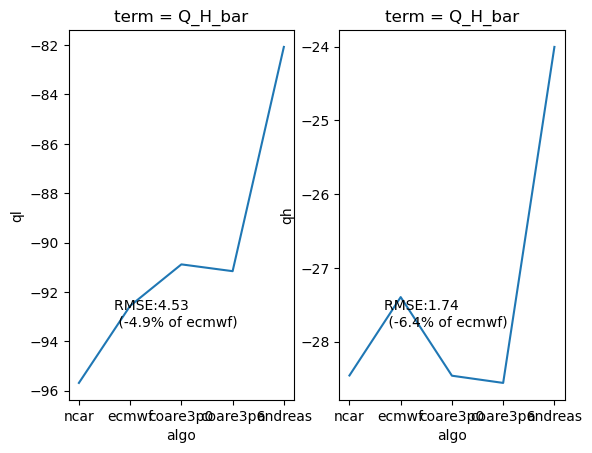

In [143]:
# Full scale
fig, axarr = plt.subplots(ncols=2)
for ax,var in zip(axarr.flat,['ql', 'qh']):
    da = global_mean[var].sel(term='Q_H_bar')
    da.plot(ax=ax)
    rmse = np.sqrt(((da-da.mean())**2).mean())
    ax.text(0.2, 0.2,f"RMSE:{rmse.load().data:.2f} \n ({(rmse/da.sel(algo='ecmwf')*100).data:.1f}% of ecmwf)", transform=ax.transAxes)

<Figure size 640x480 with 0 Axes>

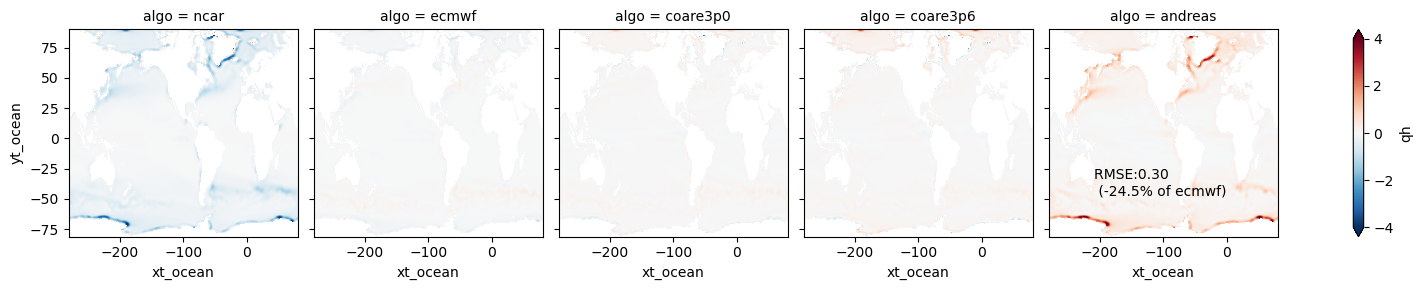

<Figure size 640x480 with 0 Axes>

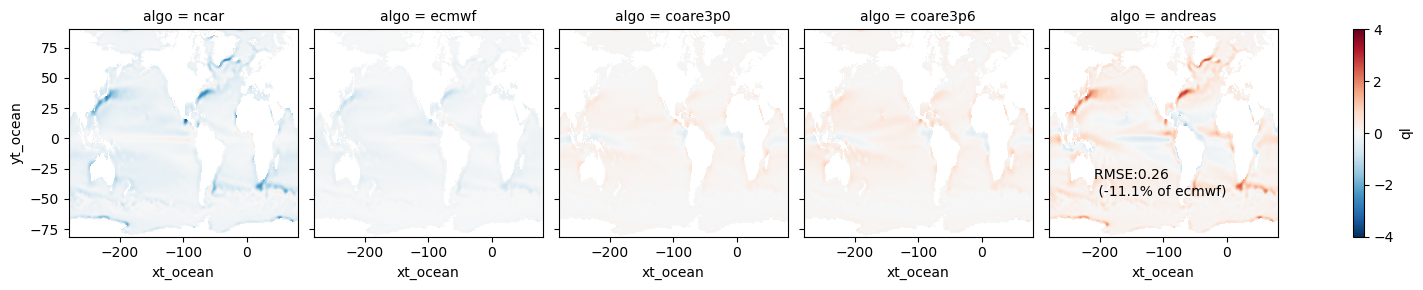

In [173]:
# difference in spatial pattern
pattern_diff = ds_small_scale_mean.sel(term='Q_star_star')
pattern_diff
for var in pattern_diff.data_vars:
    da = pattern_diff[var]
    rmse = np.sqrt(((da-da.mean('algo'))**2).mean(['xt_ocean','yt_ocean', 'algo']))
    rmse_relative = (rmse/da.sel(algo='ecmwf').mean(['xt_ocean', 'yt_ocean'])).load()
    plt.figure()
    (da-da.mean('algo')).plot(col='algo', vmax=4)
    ax = plt.gca()
    ax.text(0.2, 0.2,f"RMSE:{rmse.load().data:.2f} \n ({rmse_relative.data*100:.1f}% of ecmwf)", transform=ax.transAxes)
    plt.show()